In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow import keras
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.7.0
2.7.0


In [2]:
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
import pandas as pd

def load_data(data_path='data'):
    train_csv_path = os.path.join(data_path, "train.csv")
    test_csv_path = os.path.join(data_path, "test.csv")
    return pd.read_csv(train_csv_path, index_col='Id'), pd.read_csv(test_csv_path, index_col='Id')

train, test = load_data()

/home/marek/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
num_classes = train['Cover_Type'].nunique()
input_shape = (train.shape[1]-1)

In [5]:
train['Cover_Type'].nunique()

7

In [6]:
y_train = train['Cover_Type']

In [7]:
train.drop('Cover_Type', axis=1, inplace=True)

In [8]:
train.shape

(4000000, 54)

In [9]:
test.shape

(1000000, 54)

In [10]:
y_binary = to_categorical(y_train.values-1)

In [11]:
y_binary.shape

(4000000, 7)

In [34]:
input_shape

54

In [12]:
from sklearn.preprocessing import RobustScaler

In [13]:
transformer = RobustScaler().fit(train)

In [14]:
train = transformer.transform(train)

In [15]:
test = transformer.transform(test)

In [16]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[input_shape]),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(num_classes, activation='softmax'),
])


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               14080     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

In [19]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(min_delta=0.0005, patience=4, restore_best_weights=True)

In [40]:
batch_size = 1024
epochs = 25

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train, 
                    y_binary, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[early_stopping], 
                    validation_split=0.2,
                    workers=8,
                    use_multiprocessing=True,
                   )


Epoch 1/25
3125/3125 [==============================] - 31s 10ms/step - loss: 0.0984 - categorical_accuracy: 0.9568 - val_loss: 0.0983 - val_categorical_accuracy: 0.9564
Epoch 2/25
3125/3125 [==============================] - 33s 11ms/step - loss: 0.0982 - categorical_accuracy: 0.9568 - val_loss: 0.0974 - val_categorical_accuracy: 0.9569
Epoch 3/25
3125/3125 [==============================] - 34s 11ms/step - loss: 0.0977 - categorical_accuracy: 0.9569 - val_loss: 0.0973 - val_categorical_accuracy: 0.9567
Epoch 4/25
3125/3125 [==============================] - 32s 10ms/step - loss: 0.0975 - categorical_accuracy: 0.9571 - val_loss: 0.0970 - val_categorical_accuracy: 0.9568
Epoch 5/25
3125/3125 [==============================] - 33s 11ms/step - loss: 0.0972 - categorical_accuracy: 0.9571 - val_loss: 0.0964 - val_categorical_accuracy: 0.9571
Epoch 6/25
3125/3125 [==============================] - 34s 11ms/step - loss: 0.0969 - categorical_accuracy: 0.9572 - val_loss: 0.0967 - val_categoric

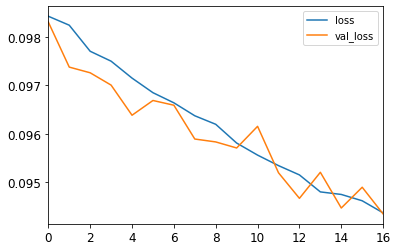

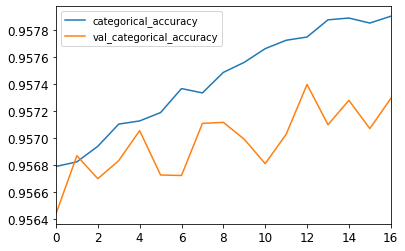

In [41]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()
# plt.ylim([0.985, 1.0])

In [42]:
predictions = model.predict(test)

In [43]:
predictions_cat = predictions.argmax(axis=1)+1

In [44]:
predictions_cat.shape

(1000000,)

In [45]:
predictions[0]

array([7.8724815e-07, 9.9998903e-01, 9.8301953e-06, 9.8931409e-08,
       1.0204589e-08, 2.4884002e-07, 7.8306694e-09], dtype=float32)

In [46]:
predictions_cat[0]

2

In [47]:
sub = pd.DataFrame({'Id': list(range(4000000,5000000)), 'Cover_Type': predictions_cat})
sub.shape

(1000000, 2)

In [48]:
sub.to_csv("data/submission_07_robust_scaler_more_training_2.csv", index=False)

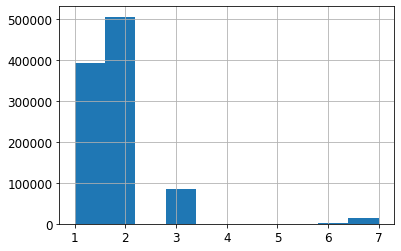

In [30]:
sub['Cover_Type'].hist()